## Statistical Analysis

Exploratory analysis revealed a number of potential predicting factors to determine if a guest will cancel. We can see that guests are more likely to cancel if they are from an OTA or book with a larger lead time, and guests with babies are far less likely to cancel. We want to now consider what other variables may contribute to cancellations, such as 'agent', 'distribution_channel', 'is_repeated_guest', 'country', 'arrival_date_month', ‘kids’ and 'hotel'. Since these variables are categorical in nature, my approach will utilize the chi-squared test for inferential analysis.
To perform the chi-squared test, we create a contingency table of observed values and calculate the expected frequencies assuming the null hypothesis. Following this we calculate the chi-squared statistic with the following formula:

$$\chi^2 = \sum_\ \frac{(O - E)^2}{E}$$
Once this statistic is calculated, we compare it to the critical values of the chi-squared distribution, calculated with the degrees of freedom and the certainty level (we use the 95% convention). Assuming the null hypothesis is true, we can reject it if our test statistic is greater than our critical value. Below is an analysis of each of the identified variables with the result.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# import appropriate statistical modules
from scipy.stats import chisquare
from scipy.stats import chi2
from scipy.stats import chi2_contingency
from scipy.stats import norm
from scipy.stats import t
from numpy.random import seed
from scipy import stats

In [2]:
hotels = pd.read_csv('data/hotels_clean.csv', index_col=0)

In [3]:
# Map months of the year to numeric values to create arrival date column for exploration
d = {'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12, 'January':1, 'February':2, 'March':3, 'April':4, 'May': 5, 'June':6}
hotels.arrival_date_month = hotels.arrival_date_month.map(d)

### Analysis of Categorical Variables

In [4]:
# define function to output chi-squared test and results
def chi2results(var1, var2, prob):
    observed = pd.crosstab(var1, var2)
    chi_square, p_val, dof, expected = chi2_contingency(observed)
    critical = chi2.ppf(prob, dof)
    
    if abs(chi_square) >= critical:
        result = 'Dependent (reject H0)'
    else:
        result = 'Independent (fail to reject H0)'
    alpha = 1.0 - prob
    
    return chi_square, critical, p_val, dof, alpha, result

In [5]:
# two way table of market segment vs cancellations
observed = pd.crosstab(hotels.is_canceled, hotels.market_segment)
print(observed)

market_segment  Aviation  Complementary  Corporate  Direct  Groups  \
is_canceled                                                          
0                    185            646       4302   10672    7714   
1                     52             97        992    1934   12097   

market_segment  Offline TA/TO  Online TA  
is_canceled                               
0                       15908      35737  
1                        8311      20739  


In [6]:
# set columns to test
cat_cols = list(hotels.describe(exclude=[np.number]).columns.drop(['reservation_status', 'reservation_status_date', 
                                                                   'deposit_type', 'assigned_room_type', 'meal']))
test_col = 'is_canceled'

# Creating an empty Dataframe with column names only
chi_square_results = pd.DataFrame(columns=['chi_square', 'critical_val', 'p_val', \
                                            'dof', 'alpha', 'result'], index = cat_cols)
for col in cat_cols:
    res = chi2results(hotels[test_col], hotels[col], prob = 0.95)
    chi_square_results.loc[col] = [res[0], res[1], res[2], res[3], res[4], res[5]]

chi_square_results[['p_val', 'result']]

,p_val,result
hotel,0,Dependent (reject H0)
country,0,Dependent (reject H0)
market_segment,0,Dependent (reject H0)
distribution_channel,0,Dependent (reject H0)
reserved_room_type,9.28632e-134,Dependent (reject H0)
customer_type,0,Dependent (reject H0)
kids,1.15309e-05,Dependent (reject H0)


In [7]:
chi_square_results.to_csv(r'/Users/mattmerrill/Springboard/Capstone/Predicting_Hotel_Cancellations/Jupyter_Notebooks/data/chi_square_results.csv', index=True)

> The null hypothesis is rejected for each of the tested columns, suggesting an association with cancellations for each variable.

### Analysis of Numerical Variables

To perform statistical analysis on numerical predictors, we calculate the t-statistic and determine the corresponding p-value. If the p-value is less than the 5% threshold for our 95% confidence interval we can consider this variable statistically significant in determining cancellations.

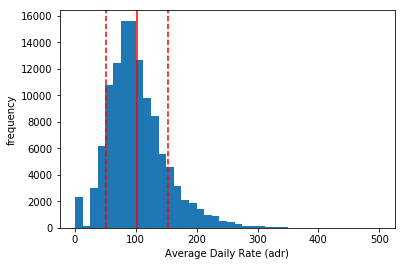

In [8]:
mean = np.mean(hotels['adr'])
std = np.std(hotels['adr'], ddof = 1)
_ = plt.hist(hotels['adr'], bins = 40, range = (0, 500))
_ = plt.xlabel('Average Daily Rate (adr)')
_ = plt.ylabel('frequency')
_ = plt.axvline(mean, color='r')
_ = plt.axvline(mean+std, color='r', linestyle='--')
_ = plt.axvline(mean-std, color='r', linestyle='--')
_ = plt.show()

In [9]:
print('mean daily rate ' + str(round(mean, 2)))
print('standard deviation ' + str(round(std, 2)))

mean daily rate 101.83
standard deviation 50.54


> The null hypothesis for the average daily rate is that it has no influence on whether or not a booking is likely to be canceled. 

In [10]:
# Define samples
sample0 = hotels[hotels.is_canceled == 1]['adr']
sample1 = hotels[hotels.is_canceled == 0]['adr']
n_0 = len(sample0)
n_1 = len(sample1)
# Define mean and standard deviation for each group
x_0 = np.mean(sample0)
x_1 = np.mean(sample1)
s_0 = np.std(sample0, ddof = 1)
s_1 = np.std(sample1, ddof = 1)
# degrees of freedom
df = n_0 + n_1 - 2

In [11]:
# calculate t-statistic and p-value
t, pval = stats.ttest_ind_from_stats(x_0, s_0, n_0, x_1, s_1, n_1)

print(t, pval)

16.46279565898682 7.925118757542334e-61


The results reject the null hypothesis. The confidence interval is far greater than the accepted 95% needed to accept this outcome. Thus we can conclude that the average daily rate is important in determining if a booking will be canceled. Next we will determine the significance of each of the other continuous variables and enter the results in a data frame to be analyzed. The following code summarizes the findings. 

In [12]:
def significance(col):
    ''' this function will return the t-stat and pval of a feature of interest '''
    # Define samples
    sample0 = hotels[hotels.is_canceled == 1][col]
    sample1 = hotels[hotels.is_canceled == 0][col]
    n_0 = len(sample0)
    n_1 = len(sample1)
    
    # Define mean and standard deviation for each group
    x_0 = np.mean(sample0)
    x_1 = np.mean(sample1)
    s_0 = np.std(sample0, ddof = 1)
    s_1 = np.std(sample1, ddof = 1)
    
    # degrees of freedom
    df = n_0 + n_1 - 2
    t, pval = stats.ttest_ind_from_stats(x_0, s_0, n_0, x_1, s_1, n_1)
    
    if pval <= 0.05:
        result = 'Dependent (reject H0)'
    else:
        result = 'Ind (fail to reject H0)'
        
    return t, pval, result

In [13]:
# List of numerical excluding features with potential for data leakage. 
num_cols = list(hotels.describe(include=[np.number]).columns.drop(['stays_in_week_nights', 'stays_in_weekend_nights', 
                                                                   'adults', 'children', 'is_canceled', 
                                                                   'total_of_special_requests', 
                                                                   'required_car_parking_spaces', 'booking_changes']))

# Creating an empty Dataframe with column names only
t_stat_results = pd.DataFrame(columns=['t_stat', 'p_val', 'result'], index = num_cols)

for col in num_cols:
    res = significance(col)
    t_stat_results.loc[col] = [res[0], res[1], res[2]]

t_stat_results

,t_stat,p_val,result
lead_time,105.941,0,Dependent (reject H0)
arrival_date_year,5.76564,8.15497e-09,Dependent (reject H0)
arrival_date_month,3.80358,0.00014269,Dependent (reject H0)
arrival_date_week_number,2.81132,0.00493474,Dependent (reject H0)
arrival_date_day_of_month,-2.11021,0.034842,Dependent (reject H0)
babies,-11.7794,5.19376e-32,Dependent (reject H0)
is_repeated_guest,-29.4037,2.34542e-189,Dependent (reject H0)
previous_cancellations,38.2871,0,Dependent (reject H0)
previous_bookings_not_canceled,-19.851,1.49641e-87,Dependent (reject H0)
agent,-16.0903,3.43391e-58,Dependent (reject H0)


In [14]:
t_stat_results.to_csv(r'/Users/mattmerrill/Springboard/Capstone/Predicting_Hotel_Cancellations/Jupyter_Notebooks/data/t_stat_results.csv', index=True)

Our findings suggest a large number of significant features to use in our model. However each of the confirmed statistically significant features must be examined to determine if they may cause data leakage. Hotel bookings typically change over time when guests choose to customize their reservation after the booking data. Some of these options affect how their profile is logged, making those customers who followed through with their booking seem more distinct than those who did not. For example, a customer who makes changes leading up to their booking will by far more likely to keep the reservation. Since our goal is to predict the possibility of a canceled booking given only the initial parameters of a booking, we must eliminate many of these sources of data leakage. After examining the data and reading carefully into the source of the data, it was determined that all features that hold the potential for changing over time must be eliminated. This was done prior to the statistical analysis and eliminated the following features:

> Assigned room type, booking changes, deposit type, reservation status, reservation status date, total of special requests, stays in week nights, stays in weekend nights, meal and adults